# Debiasing Word Embeddings

This project is based off a widely-cited paper called [Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf), by Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai (2016).

In the paper, they demonstrate two important things:
1.   word embeddings learn deep meanings and subtle interconnections between words, and that includes both overtly and covertly sexist meanings of words
2.   there are ways to quantify and mitigate that bias

We'll be roughly following along with the methodology of the paper — if parts of this project are unclear or don't make sense, it is strongly encourage to read the paper and see if that clears things up. Even if one isn't confused one should read the paper anyway (it's *super* interesting).

**Note:** The interaction between language and gender-based discrimination is a complex topic that goes far beyond our ability to quantify and vectorize words. We also recognize that gender isn't a binary, and the understanding of gender exhibited in this project is quite naive. Regardless, there have been [well-documented instances](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon-scraps-secret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G) of programs exhibiting clearly sexist behaviors. The point of this project is to name that dynamic and give you some tools to think about it.

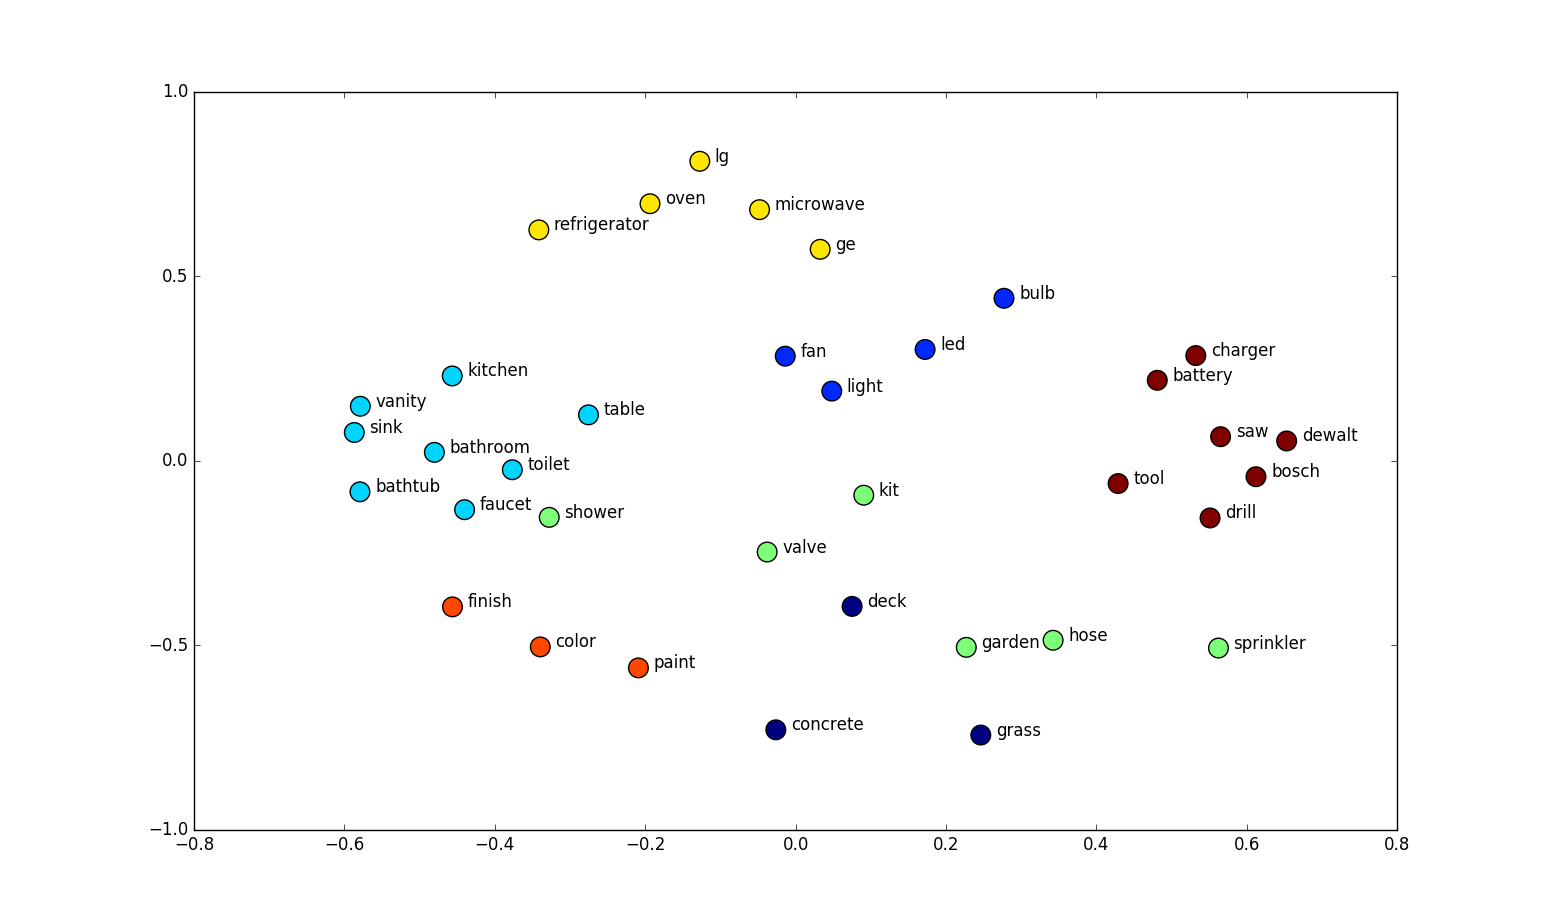

In [1]:
import pickle
from google.colab import drive, files
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import math
from IPython.display import Image

For this project, we'll be using a truncated version of the [Global Vectors for Word Representation (GloVe) word embedding](https://nlp.stanford.edu/projects/glove/) dataset. These are 300-dimensional vectors that were trained on the Wikipedia corpus circa 2014 and an open source data repository of newswire text called Gigaword 5. There are 6 billion tokens (individual words) in the corpus.

For the sake of ease, we've done some preprocessing of the data for you — instead of a 400,000-word embedding, you have a well-structured embedding of the 50,000 most common words. We've also removed all of the punctuation, and stored it compressed in the same folder as this lab so that it's accessible in Colab.

In [3]:
# load dataset to vector_dict (linked above)
drive.mount('/gdrive', force_remount=True)
#path = "/gdrive/Shared drives/CS147 - F19 UTA/Course Development/Labs/language_debiasing/preprocessed_glove.pickle" # will change
path = "/gdrive/My Drive/Colab Notebooks/Tutorials/preprocessed_glove.pickle" # if you make a copy of preprocessed_glove.pickle into your drive's root directory, this should be the right path.

f = open(path, 'rb')
vector_dict = pickle.load(f) #shape of (50000,300)
f.close()

Mounted at /gdrive


Using `vector_dict` (which we just unpickled), we get a `vector_matrix` and a `word_list` with corresponding indices. These will be useful when we are trying to manually inspect some of the gender bias in GLoVe embeddings.

In [5]:
word_list = []
vector_matrix = np.zeros(shape=(50000, 300))
for i, (word, vec) in enumerate(vector_dict.items()):
  word_list.append(word)
  vector_matrix[i] = vec

In [6]:
vector_dict['he'] - vector_dict['she'] + vector_dict['queen']

array([-1.60300000e-01,  4.74643000e-01,  1.88287000e-01,  4.95810000e-01,
        2.71333000e-01,  4.07900000e-02,  1.16730000e-01,  2.07849000e-01,
       -2.68340000e-01, -7.71590000e-01, -1.84408000e-01, -8.91900000e-02,
       -3.88000000e-02,  5.98040000e-01,  1.25720000e-01,  2.31843000e-01,
       -1.02951800e-01, -2.21680000e-01,  5.54220000e-02, -2.42375000e-01,
       -5.62900000e-01,  3.34610000e-01,  1.15552000e-01,  4.69655000e-01,
        1.23050000e-01, -4.79914000e-01, -3.96499000e-01,  3.56910000e-02,
        1.75066000e-01, -9.51950000e-02,  5.78763000e-01, -3.20320000e-02,
       -2.45707000e-01,  4.30723000e-01, -2.14830000e-01, -1.84830000e-01,
        4.02727000e-01,  9.11587500e-02, -6.49743000e-01, -1.48908300e-01,
       -2.19500000e-02,  4.31330000e-01, -7.07771000e-01,  7.27095000e-01,
        1.26107000e-01,  2.14843000e-01,  1.83726000e-01, -1.32365000e-01,
        3.08501000e-01, -4.22460000e-01, -6.90947000e-01,  2.17647000e-01,
        8.47500000e-02,  

## Part 1: The Initial Embedding

As stated in the paper, "the vector differences between words in embeddings have been shown to represent relationships between words. For example, given an analogy puzzle, “man is to king as woman is to x”, simple arithmetic of the embedding vectors finds that x=queen is the best answer because vector(man) - vector(woman) is roughly equal to vector(king) - vector(queen)".

We've implemented code below that will help you clearly observe how gender functions in this word embedding. English is not a language that embeds gender into most words. That means that some of the results are reflect meaningful gendered linguistic differences (between the pronouns "he" and "she", for example). Other embeddings, however, clearly illustrate the sexist biases that are a part of language. 

In [7]:
"""
Use a basic similarity calculation (cosine similarity) to find the closest words
to an input vector.
"""
def find_similar(vector_matrix, input_vector):
    # compute cosine similarity of input_vevector with everything else in our vocabulary 
    cosine_similarities = linear_kernel(input_vector, vector_matrix).flatten()
    
    # sort by cosine similarities, to get the most similar vectors on top
    related_words_indices = [i for i in cosine_similarities.argsort()[::-1]]
    return [index for index in related_words_indices][0:5]

"""
Use find_similar() to manually observe how gendered biases are encoded into the
embedding.
"""
def get_gendered_analogies(word):
  # error check
  if word not in word_list:
    print("Sorry, this word isn't in our observed vocabulary. Try another one!")
    return
  
  #Create a vector x that has the same vector difference to the word as "she" to "he"
  # she - he = x - word <=> x = she - he + word
  x = vector_dict['she'] - vector_dict['he'] + vector_dict[word]
  x = np.reshape(x, (1, 300))
  
  # get vectors similar to that input x
  gender_shifted = find_similar(vector_matrix, x)
  for i in gender_shifted:
    print(word_list[i])

Change the word in the call to `get_gendered_analogies()` below to see what gendered embeddings are encoded into GloVe. Note that this is the analogy "he is to she as `input_word` is to `output_word`"; if you want to try out some of your own, `input_word` should be one that is traditionally coded as "male". (Or, you can modify your implementation of `get_gendered_analogies()` above if you want to try a word traditionally coded as "female".)

The observed gender bias sometimes is an appropriate classifier in the situation. For example, try:


* brother
* king
* prostate
* monastery
* masculine


Other times the gender bias in the model reflects sexist societal stereotypes. For example, try:
* programmer
* brilliant
* handsome
* doctor
* superstar
* snappy
* pharmaceuticals
* warrior
* genius

You should be seeing some interesting results if you've implemented `get_gendered_analogies` correctly.

In [8]:
get_gendered_analogies('beautiful') # fill in this method with the word you want to look at.

beautiful
lovely
actress
her
gorgeous


## Part 2: the gender subspace

So from some qualitative observations of which words are associated with each other, it's pretty clear that GloVe has learned sexist connotations of words. But how should we think about gender quantitatively in this embedding?

If we can come up with several vectors for words that are clearly gender-paired, we can identify a "gender subspace" of the 300-dimensional vector space that these words live in. In the paper, they considered the following gender-paired, (relatively) neutral words:

- she/he
- her/his
- woman/man
- herself/himself
- daughter/son
- mother/father
- sister/brother
- gal/guy
- girl/boy
- female/male
- feminine/masculine

We can then use some observations from linear algebra to see how significant gender is in this embedding and what gender looks like quantitatively in the embedding space.

In [18]:
# generate a matrix full of random numbers to serve as a control
control_subspace = np.random.randn(11, 300)

# Create a numpy array of size (11, 300) with difference vectors between the above gender-paired words.
gender_subspace = np.array([ vector_dict['she'] - vector_dict['he'],
                            vector_dict['her'] - vector_dict['his'],
                            vector_dict['woman'] - vector_dict['man'],
                            vector_dict['herself'] - vector_dict['himself'],
                            vector_dict['daughter'] - vector_dict['son'],
                            vector_dict['mother'] - vector_dict['father'],
                            vector_dict['sister'] - vector_dict['brother'],
                            vector_dict['gal'] - vector_dict['guy'],
                            vector_dict['girl'] - vector_dict['boy'],
                            vector_dict['female'] - vector_dict['male'],
                            vector_dict['feminine'] - vector_dict['masculine']])

print(gender_subspace.shape)

(11, 300)


Now we find and plot the covariance matrices and eigenvalues of both the control and the gender subspace matrix. (The [`np.linalg`](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html) module might be helpful.)

Linear algebra refresher: covariance between two values is an indication of whether they change in the same or opposite directions. Eigenvectors (of a covariance matrix) with the largest eigenvalue is the direction along which the data set has the maximum variance. Read more about why the eigenvector with the highest eigenvalue of a covariance matrix is a principal component [here](https://math.stackexchange.com/questions/23596/why-is-the-eigenvector-of-a-covariance-matrix-equal-to-a-principal-component).

In [10]:
control_covariance = np.dot(control_subspace.T, control_subspace)
#get eigenvalues for the control subspace
control_eig_vals, _ = np.linalg.eig(control_covariance)

In [11]:
gender_covariance = np.dot(gender_subspace.T, gender_subspace)
#get eigenvalues and eigenvectors for the gender subspace
gender_eig_vals, gender_eig_vecs = np.linalg.eig(gender_covariance)

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


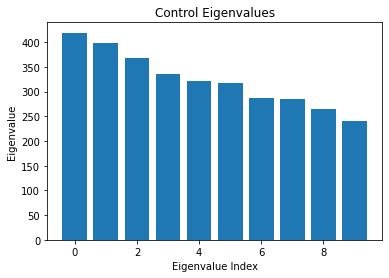

In [12]:
x = np.arange(10)

plt.bar(x, control_eig_vals[:10])
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Control Eigenvalues')

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


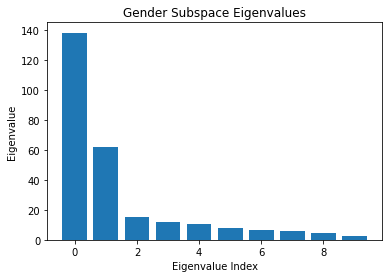

In [13]:
x = np.arange(10)

plt.bar(x, gender_eig_vals[:10])
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Gender Subspace Eigenvalues')

plt.show()

## Part 3: Debiasing
Now we're going to be debiasing the embeddings using properties of linear algebra. In this lab, we will doing a toy example — in the paper, they debias almost the entire dataset.

From part 1, we have some words that return sexist analogies that we want to debias:
* programmer
* brilliant
* handsome
* doctor
* superstar
* snappy
* pharmaceuticals
* warrior
* genius

From part 2, we also have some sense of which vectors create the "gender subspace", as well as some word-pairs that define the subspace.

(Note: In the real world, the effect is more pervasive and subtle. If we want to debias the entire dataset, it will likely be easier to explicitly identify the words that we *don't* want to debias so as to retain useful linguistic differences in gender (brother/sister, he/she, etc).)

In [14]:
# terms that have sexist encodings in GloVe
biased_words = ['programmer',
                'brilliant',
                'handsome',
                'doctor',
                'superstar',
                'snappy',
                'pharmaceuticals',
                'warrior',
                'genius',
               ]

# pairs of gendered terms without negative connotations —— to neutralize the words above, we will
# enforce that they are perpendicular to the space defined by these terms
equality_sets = [['she', 'he'],
                 ['her', 'his'],
                 ['woman', 'man'],
                 ['herself', 'himself'],
                 ['daughter', 'son'],
                 ['mother', 'father'],
                 ['brother', 'sister'],
                 ['gal', 'guy'],
                 ['girl', 'boy'],
                 ['female', 'male'],
                 ['feminine', 'masculine']
                ]

In [16]:
"""
A function that computes cosine similarities between the terms in the equality sets and the biased
words, illustrating how the terms we've listed above are coded as more masculine than feminine.

We will use this function again after we have debiased the biased words to illustrate what debiasing
actually means in this context.
"""
def test_bias(biased_words, equality_sets):
  female_similarities = []
  male_similarities = []
  
  # for each biased word
  for word in biased_words:
    word_female_similarities = []
    word_male_similarities = []
    
    # calculate similarity to the masculine and feminine terms in the equality sets
    for equality_set in equality_sets:
      f_sim = cosine_similarity(np.array([vector_dict[word]]), np.array([vector_dict[equality_set[0]]]))
      female_similarities.append(f_sim)
      word_female_similarities.append(f_sim)
      
      m_sim = cosine_similarity(np.array([vector_dict[word]]), np.array([vector_dict[equality_set[1]]]))
      male_similarities.append(m_sim)
      word_male_similarities.append(m_sim)
      
    print("========================================================")
    print("Average similarity to female-coded words for", word, ":")
    print(sum(female_similarities) / len(female_similarities))
    # print("————————————————————————————————————————————————————————")
    print("Average similarity to male-coded words for", word, ":")
    print(sum(male_similarities) / len(male_similarities))
    print('\n')
      

  print('\n\n')
  print("=================================================")
  print("Overall average similarity to female-coded words:")
  print(sum(female_similarities) / len(female_similarities))
  print("————————————————————————————————————————————————————————")
  print("Overall average similarity to male-coded words:")
  print(sum(male_similarities) / len(male_similarities))

In [17]:
test_bias(biased_words, equality_sets)

Average similarity to female-coded words for programmer :
[[0.03813556]]
Average similarity to male-coded words for programmer :
[[0.09063215]]


Average similarity to female-coded words for brilliant :
[[0.09409647]]
Average similarity to male-coded words for brilliant :
[[0.14723869]]


Average similarity to female-coded words for handsome :
[[0.12531041]]
Average similarity to male-coded words for handsome :
[[0.17915649]]


Average similarity to female-coded words for doctor :
[[0.17193337]]
Average similarity to male-coded words for doctor :
[[0.21304909]]


Average similarity to female-coded words for superstar :
[[0.16885273]]
Average similarity to male-coded words for superstar :
[[0.20710681]]


Average similarity to female-coded words for snappy :
[[0.13944215]]
Average similarity to male-coded words for snappy :
[[0.17159393]]


Average similarity to female-coded words for pharmaceuticals :
[[0.11280127]]
Average similarity to male-coded words for pharmaceuticals :
[[0.14222

Here's a a refresher about projection to new bases and normalization of vectors:

<img src="https://drive.google.com/uc?export=view&id=1ysNZE0cNq3Ku80x5jIjVX1uNjmTYYd9f">

**These** are linear algebra helper functions.

In [19]:
def project(v, basis):
  out = np.zeros((300,))
  for b in basis:
    component = np.dot(v, b) * b
    c = component.astype(float)
    out += c
  return out

def normalize(v):
  return v / np.linalg.norm(v)

We neutralize the biased words by making them orthogonal to the gender subspace that we defined above. That means that they are perpendicular to explicitly gendered vectors, and also perpendicular to the gender subspace as a whole.

To visualize what's happening here, let's imagine we have three vectors in 2d space — the vectors for a gender-paired set of terms (e.g. "he" and "she"), and a word that we have observed as having bias (e.g. "doctor"). Further, let's visualize the gender subspace that we've defined above as 1 vector. As you can see, the cosine similarity between "he" and "doctor" is greater than the similarity between "she" and "doctor", indicating gender bias.

<img src="https://drive.google.com/uc?export=view&id=1zdlIoYpsxUwUV0Gz1CmYHoORCXtzB-7C">

What we are doing when we "neutralize" a biased term like doctor is:
1. projecting its vector on to the gender subspace, then
2. subtracting the projection from the original, giving us a vector that is perpendicular to gender basis

After that, the neutralized vector should be roughly equidistant from both "he" and "she", and should have roughly the same cosine similarity.

<img src="https://drive.google.com/uc?export=view&id=1_EP0wofAr79bjbGm50htPP3LNGyCao3J">

In [20]:
def neutralize(biased_words):
  for word in biased_words: 
    # get the vector for the current word
    # neutralize it, using the previously stored gender_eig_vecs, then normalize it
    # update vector_dict to reflect the new word vector
    vec = vector_dict[word]
    proj_vec = project(vec, gender_eig_vecs)
    vector_dict[word] = normalize(vec - proj_vec)

In [21]:
neutralize(biased_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Now the cosine similarities between gendered terms for the previously sexist words are all closer to zero than before. This means that the words are orthogonal to the gender subspace and (in the eyes of the model) have less gendered connotations!

In [22]:
test_bias(biased_words, equality_sets)

Average similarity to female-coded words for programmer :
[[-0.04655764]]
Average similarity to male-coded words for programmer :
[[-0.00192684]]


Average similarity to female-coded words for brilliant :
[[0.00699142]]
Average similarity to male-coded words for brilliant :
[[0.0219652]]


Average similarity to female-coded words for handsome :
[[0.03852561]]
Average similarity to male-coded words for handsome :
[[0.05072558]]


Average similarity to female-coded words for doctor :
[[0.06898794]]
Average similarity to male-coded words for doctor :
[[0.07125401]]


Average similarity to female-coded words for superstar :
[[0.07706974]]
Average similarity to male-coded words for superstar :
[[0.07943125]]


Average similarity to female-coded words for snappy :
[[0.06791723]]
Average similarity to male-coded words for snappy :
[[0.06493751]]


Average similarity to female-coded words for pharmaceuticals :
[[0.05716518]]
Average similarity to male-coded words for pharmaceuticals :
[[0.0570

We've just done a toy example of what debiasing word vectors looks like. In the paper, they debias the *entire* word embedding dataset. To do that while maintaining an understandable meaning of gender-paired words, we also need to "equalize" all gendered words in the equality set by projecting them directly into the gender subspace.